### Connectome-informed reservoir - Echo-State Network

This tutorial demonstrates how to use the conn2res toolbox to implement
a NeuroGym task varying both local and global dynamics.

In [2]:
%matplotlib inline

import warnings
import os
import numpy as np
import pandas as pd
from sklearn.base import is_classifier
from conn2res.tasks import NeuroGymTask
from conn2res.connectivity import Conn
from conn2res.reservoir import EchoStateNetwork
from conn2res.readout import Readout
from conn2res import readout, plotting

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

First, let's initialize some constant variables.

In [3]:
# task name : perceptual decision making task
# fixation period timing (display fixation point to fix eye position of monkey): 100ms
# stimulus period timing : 2000ms
# decision period timing : 100ms
# 1 trial = 22 time steps
# dt(timestep duration) : 100ms
TASK = 'PerceptualDecisionMaking'

# define metrics to evaluate readout's model performance

METRICS = [
    'balanced_accuracy_score',
    'f1_score',
]

# define alpha values to vary global reservoir dynamics
ALPHAS = np.linspace(0, 2, 11)[1:]
print(ALPHAS)

# activation function defines local dynamics
ACT_FCN = 'tanh'  # 'sigmoid'

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


Second, let's fetch a NeuroGym task data set.

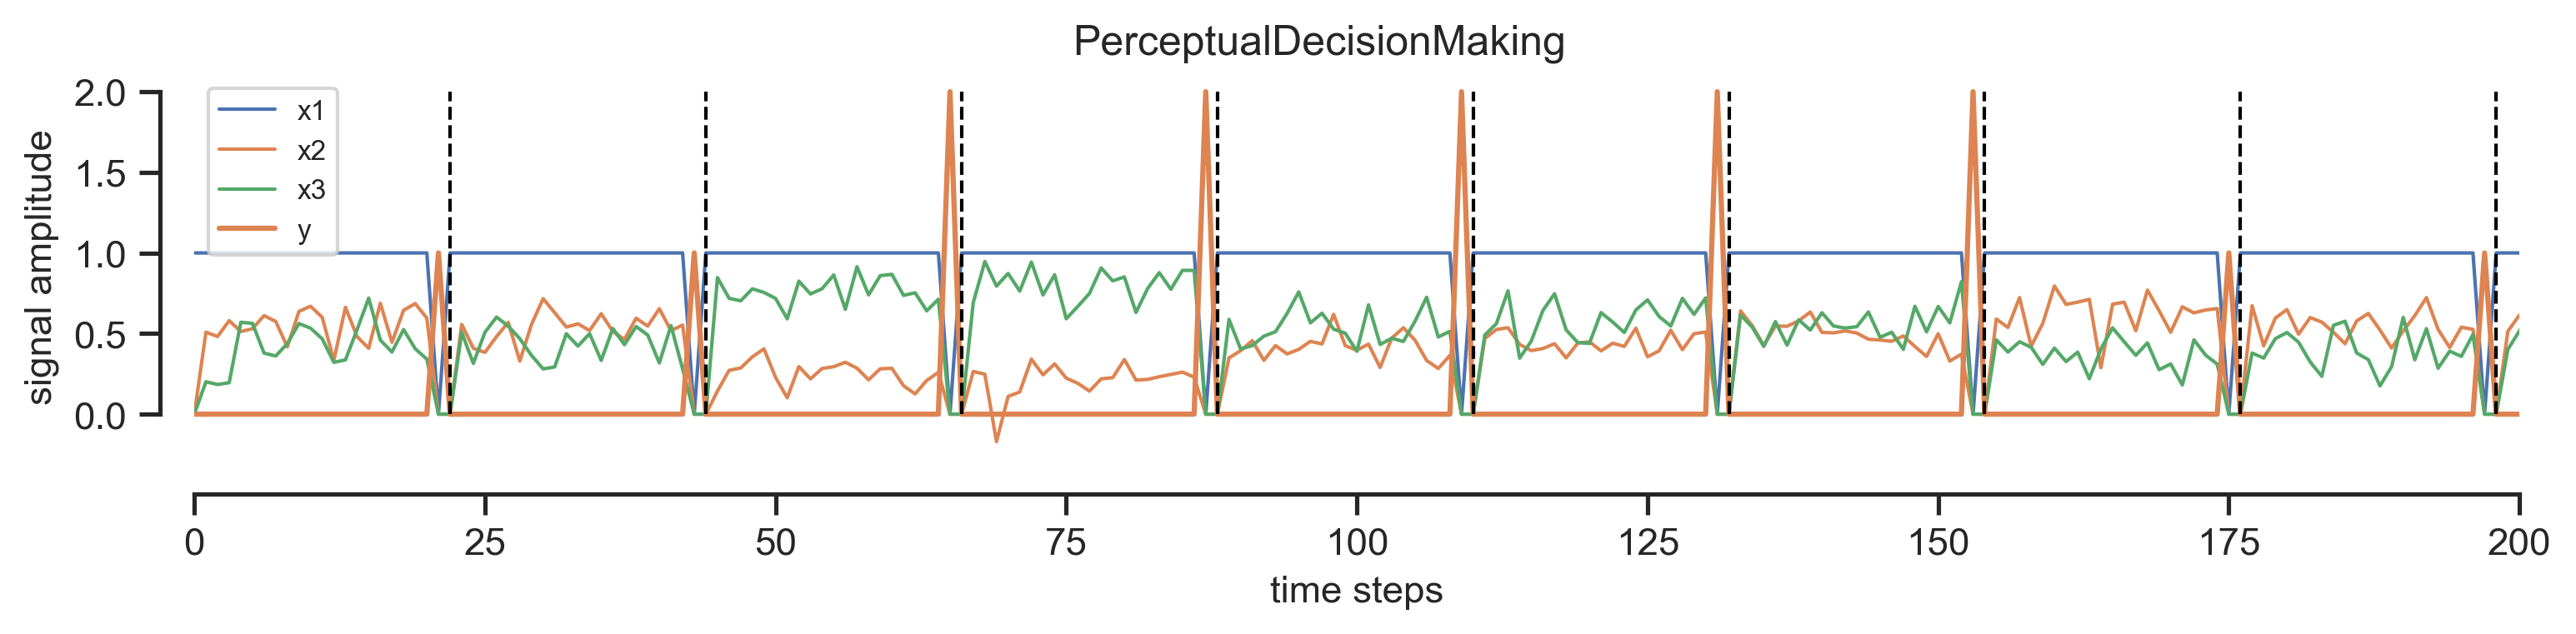

[[1.         0.         0.        ]
 [1.         0.50836664 0.20107456]
 [1.         0.48165843 0.18386017]
 [1.         0.5801953  0.19527559]
 [1.         0.5123263  0.5700384 ]
 [1.         0.5301906  0.56324387]
 [1.         0.6112253  0.37853318]
 [1.         0.57504416 0.3609839 ]
 [1.         0.41744727 0.4372051 ]
 [1.         0.6374789  0.56202346]
 [1.         0.66938865 0.5334604 ]
 [1.         0.60081816 0.46739215]
 [1.         0.33370477 0.32145238]
 [1.         0.66280276 0.3368355 ]
 [1.         0.4809069  0.52417177]
 [1.         0.40858445 0.71995836]
 [1.         0.6884184  0.45958364]
 [1.         0.4458622  0.38558766]
 [1.         0.64457095 0.52482635]
 [1.         0.6859857  0.40603513]
 [1.         0.59589654 0.3414419 ]
 [0.         0.         0.        ]]


In [4]:
# instantiate task object
task = NeuroGymTask(name=TASK)

# fetch input/output data to perform task(50 different realizations of task's dataset)
# x(list of ndarray) : observations, 각 trial마다 list item
# y(list of ndarray) : ground truth, target label, 각 trial마다 list item
x, y = task.fetch_data(n_trials=1000)

# plot input/output (x/y) data
plotting.plot_iodata(
    x, y, title=task.name,
    rc_params={'figure.dpi': 300, 'savefig.dpi': 300},
    show=True
)

# split data into training and test sets
# fraction of sampes in training set = 0.7
# 모두 list of array
x_train, x_test, y_train, y_test = readout.train_test_split(x, y)

print(x[0])

Third, let's import the connectivity matrix we are going to use to define the connections of the reservoir.  

For this we will be using the human connectome parcellated into 1015 brain regions following the Desikan Killiany atlas (Desikan, et al., 2006).

AttributeError: 'numpy.ndarray' object has no attribute 'skew'

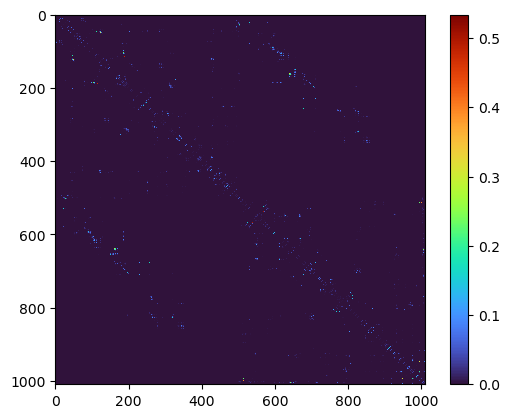

In [104]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler    # z-score normalization

# load connectivity data of one subject
conn = Conn(subj_id=0)

# scale conenctivity weights between [0,1] and normalize by spectral its radius
conn.scale_and_normalize()

fig,ax1=plt.subplots()
im=ax1.imshow(conn.w, cmap='turbo', interpolation='none')
cbar=ax1.figure.colorbar(im, ax=ax1)
#sns.jointplot(data=conn.w, kind='scatter')

A=conn.w.reshape(1010*1010)

A.skew()

#fig,ax2=plt.subplots()
#im=ax2.imshow(a, cmap='turbo', interpolation='none')
#cbar=ax2.figure.colorbar(im, ax=ax2)
#sns.jointplot(data=a, kind='scatter')

plt.show()

Let's define the set of input and output nodes.

To do so, we will use functional intrinsic networks (Yeo ,et al., 2011).

In [5]:
# perceptual dicision task의 features 개수 = 3(x1, x2, x3)
# input nodes: a random set of brain regions in the visual system
input_nodes = conn.get_nodes(
    'random', nodes_from=conn.get_nodes('VIS'),
    n_nodes=task.n_features
)

# 1015개로 쪼갠 region을 대응되는 숫자로 표현한건가?
# print(conn.get_nodes('VIS'), input_nodes)

In [6]:
# output nodes: all brain regions in the somatomotor system
output_nodes = conn.get_nodes('SM')

# print(output_nodes,output_nodes.shape)

Now we will create the input connectivity matrix to define the connections between the input layer (source nodes where the input signal is coming from) and the input nodes in the reservoir.

In [11]:
# conn.n_nodes : active nodes # inconnectivity matrix
w_in = np.zeros((task.n_features, conn.n_nodes))
# input node에 해당하는 brain region 초기화
w_in[:, input_nodes] = np.eye(task.n_features)

print(w_in, np.shape(w_in))
len(np.shape(w_in))
# print(w_in[:, 887], w_in[:, 381], w_in[:, 387]) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (3, 1010)


2

Next, we will simulate the dynamics of the reservoir. We will evaluate the effect of local network dynamics by using different activation functions. We will also evaluate network performance across dynamical regimes by parametrically tuning alpha, which corresponds to the spectral radius of the connectivity matrix (alpha parameter).

In [8]:
# instantiate an Echo State Network object
# conn.w : connectivity matrix of subject(1010x1010)
esn = EchoStateNetwork(w=conn.w, activation_function=ACT_FCN)

# instantiate a Readout module object 
# estimator, model : Ridge classifier
readout_module = Readout(estimator=readout.select_model(y))


			----- alpha = 0.2 -----

			----- alpha = 0.4 -----

			----- alpha = 0.6 -----

			----- alpha = 0.8 -----

			----- alpha = 1.0 -----


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



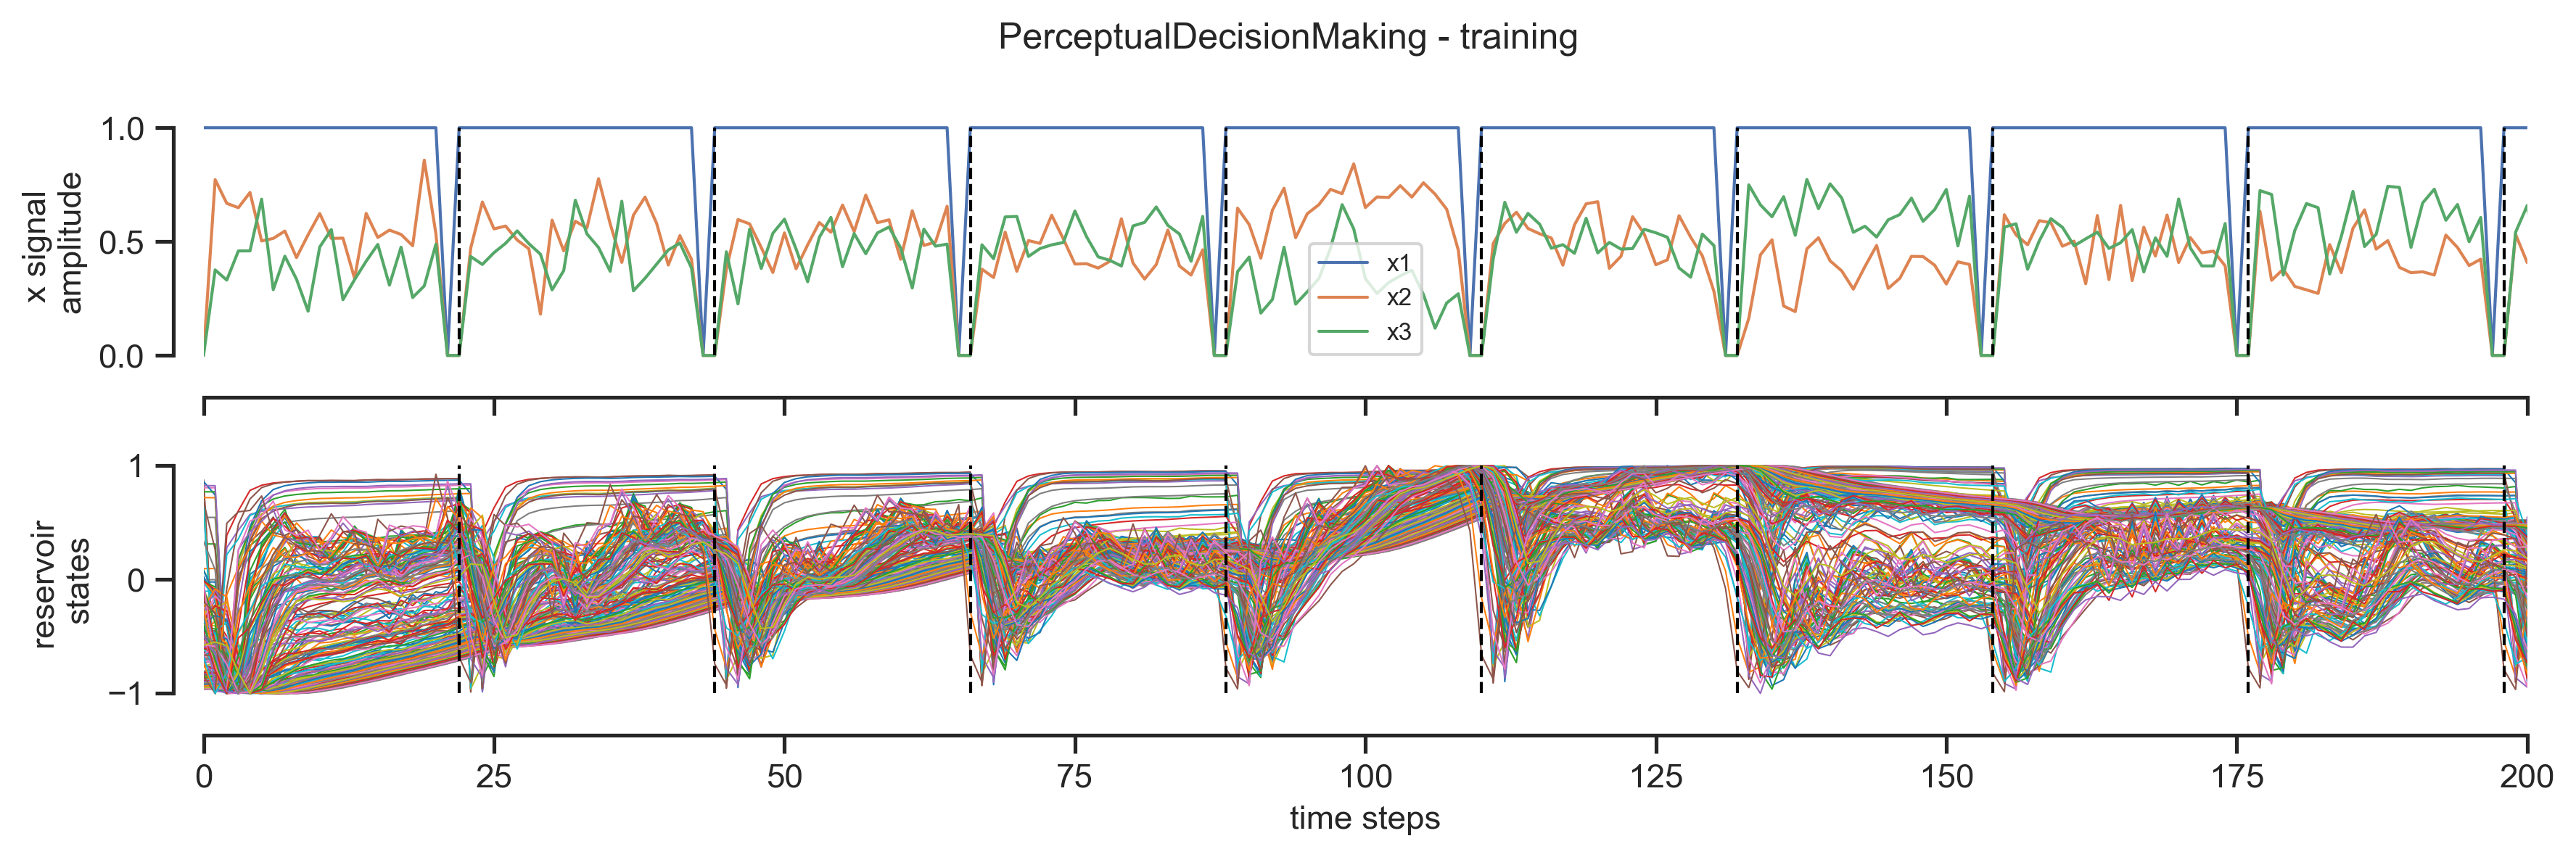

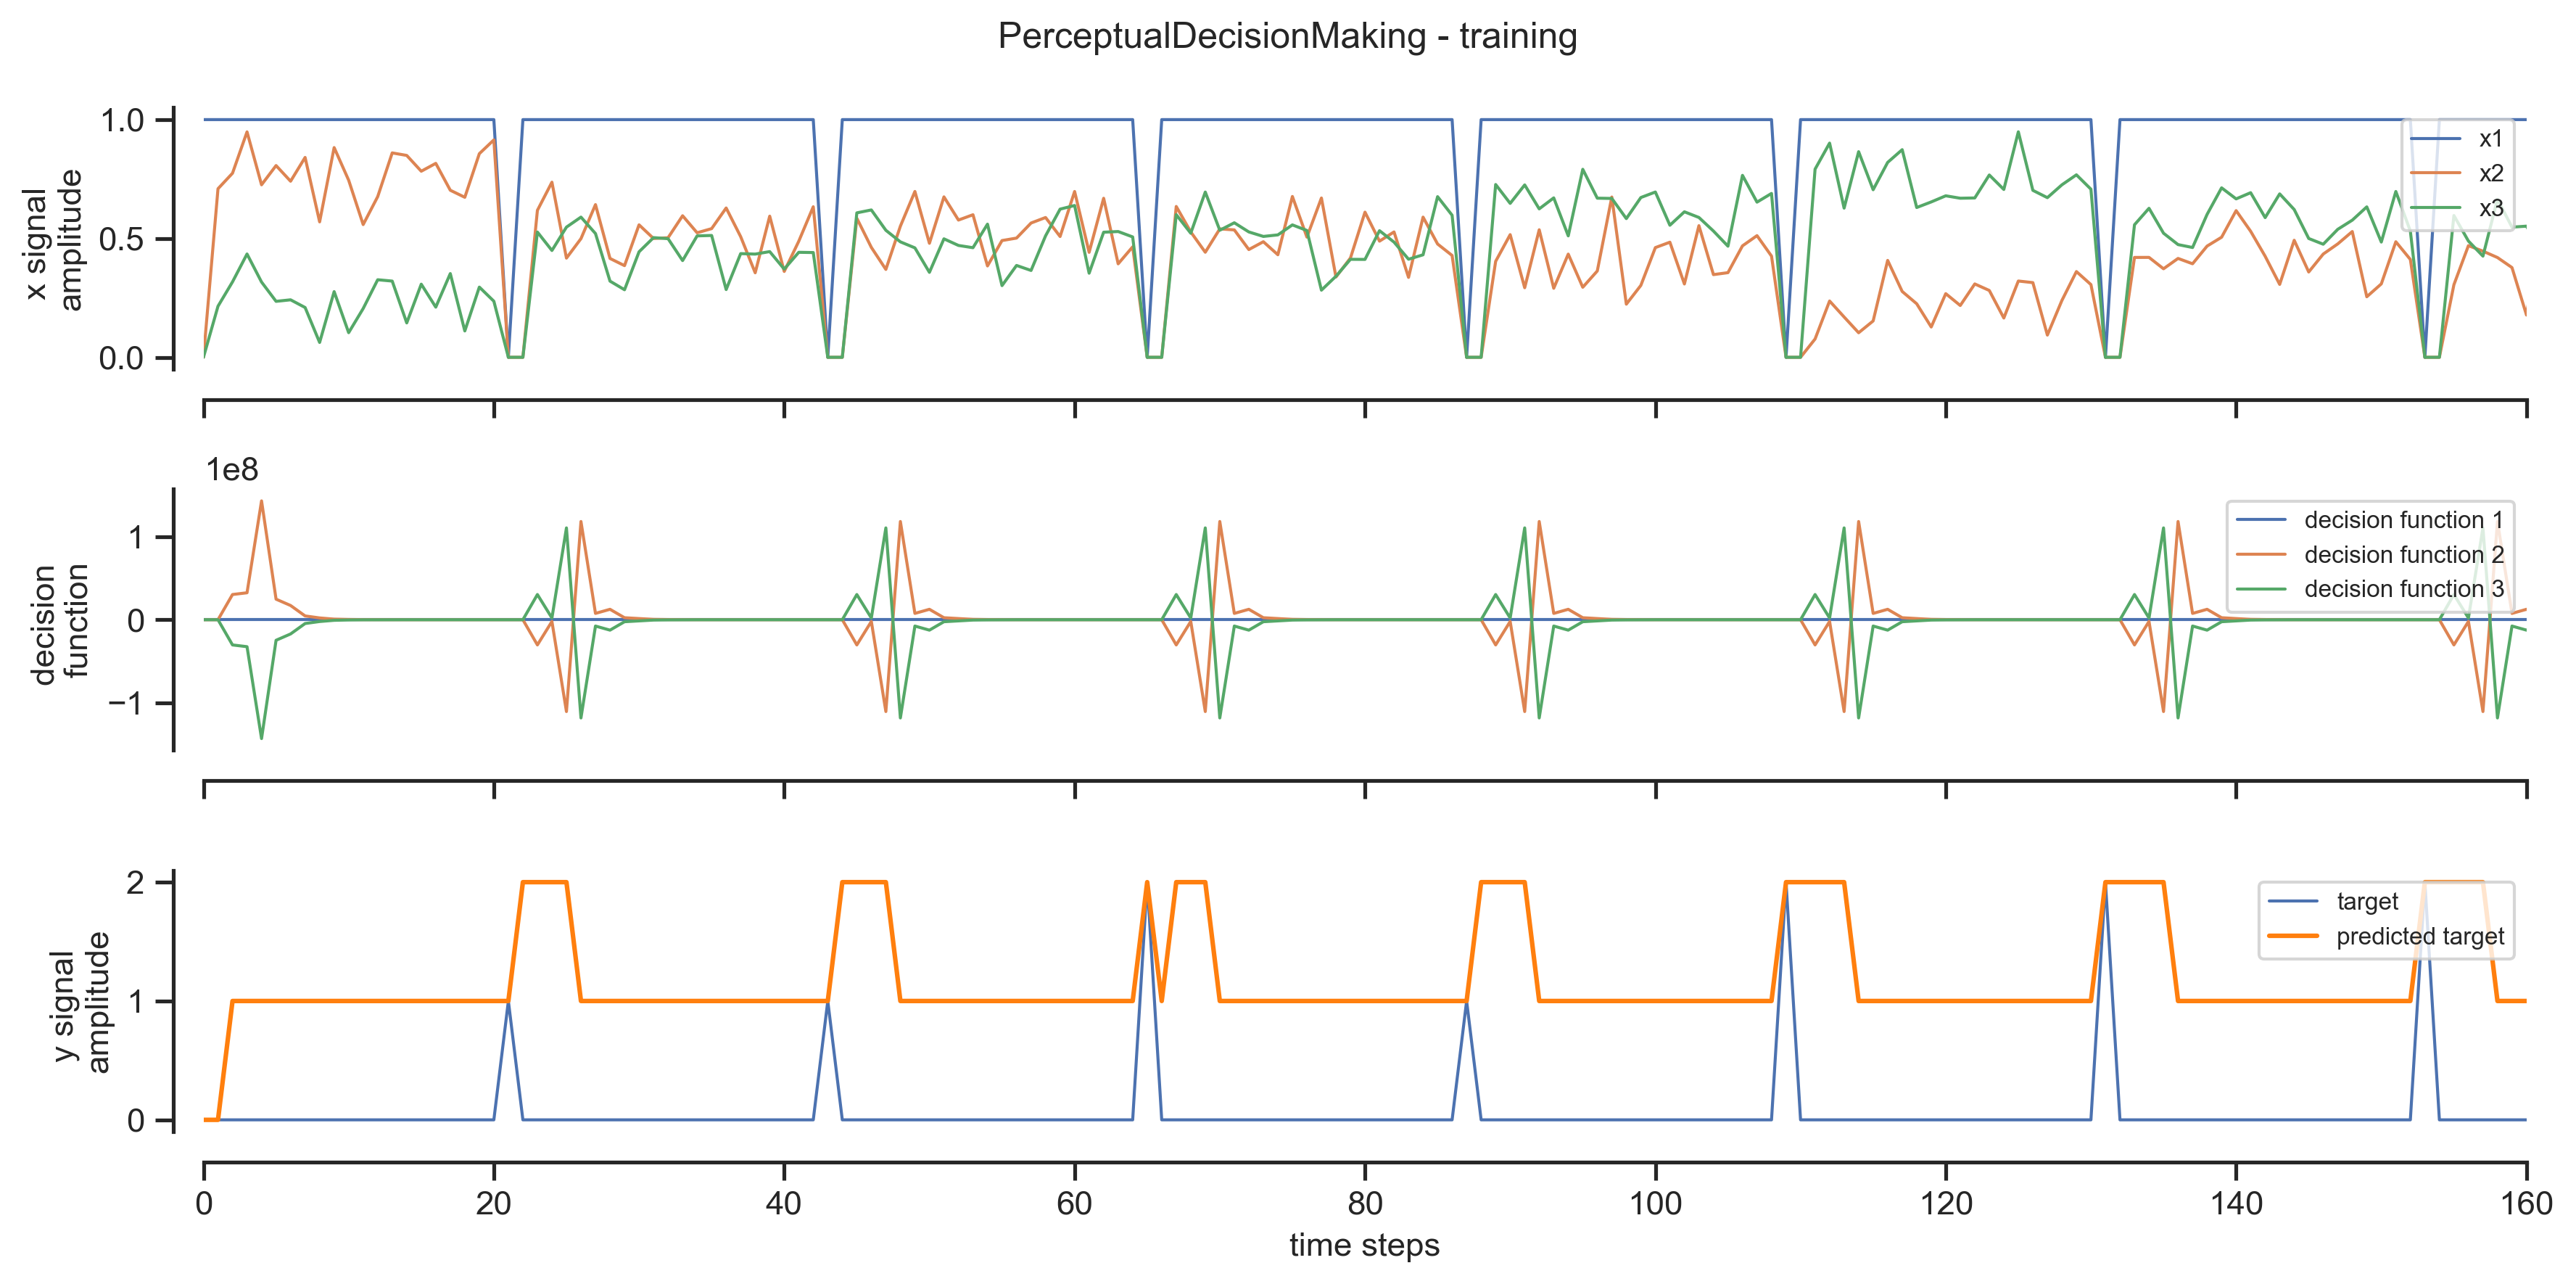

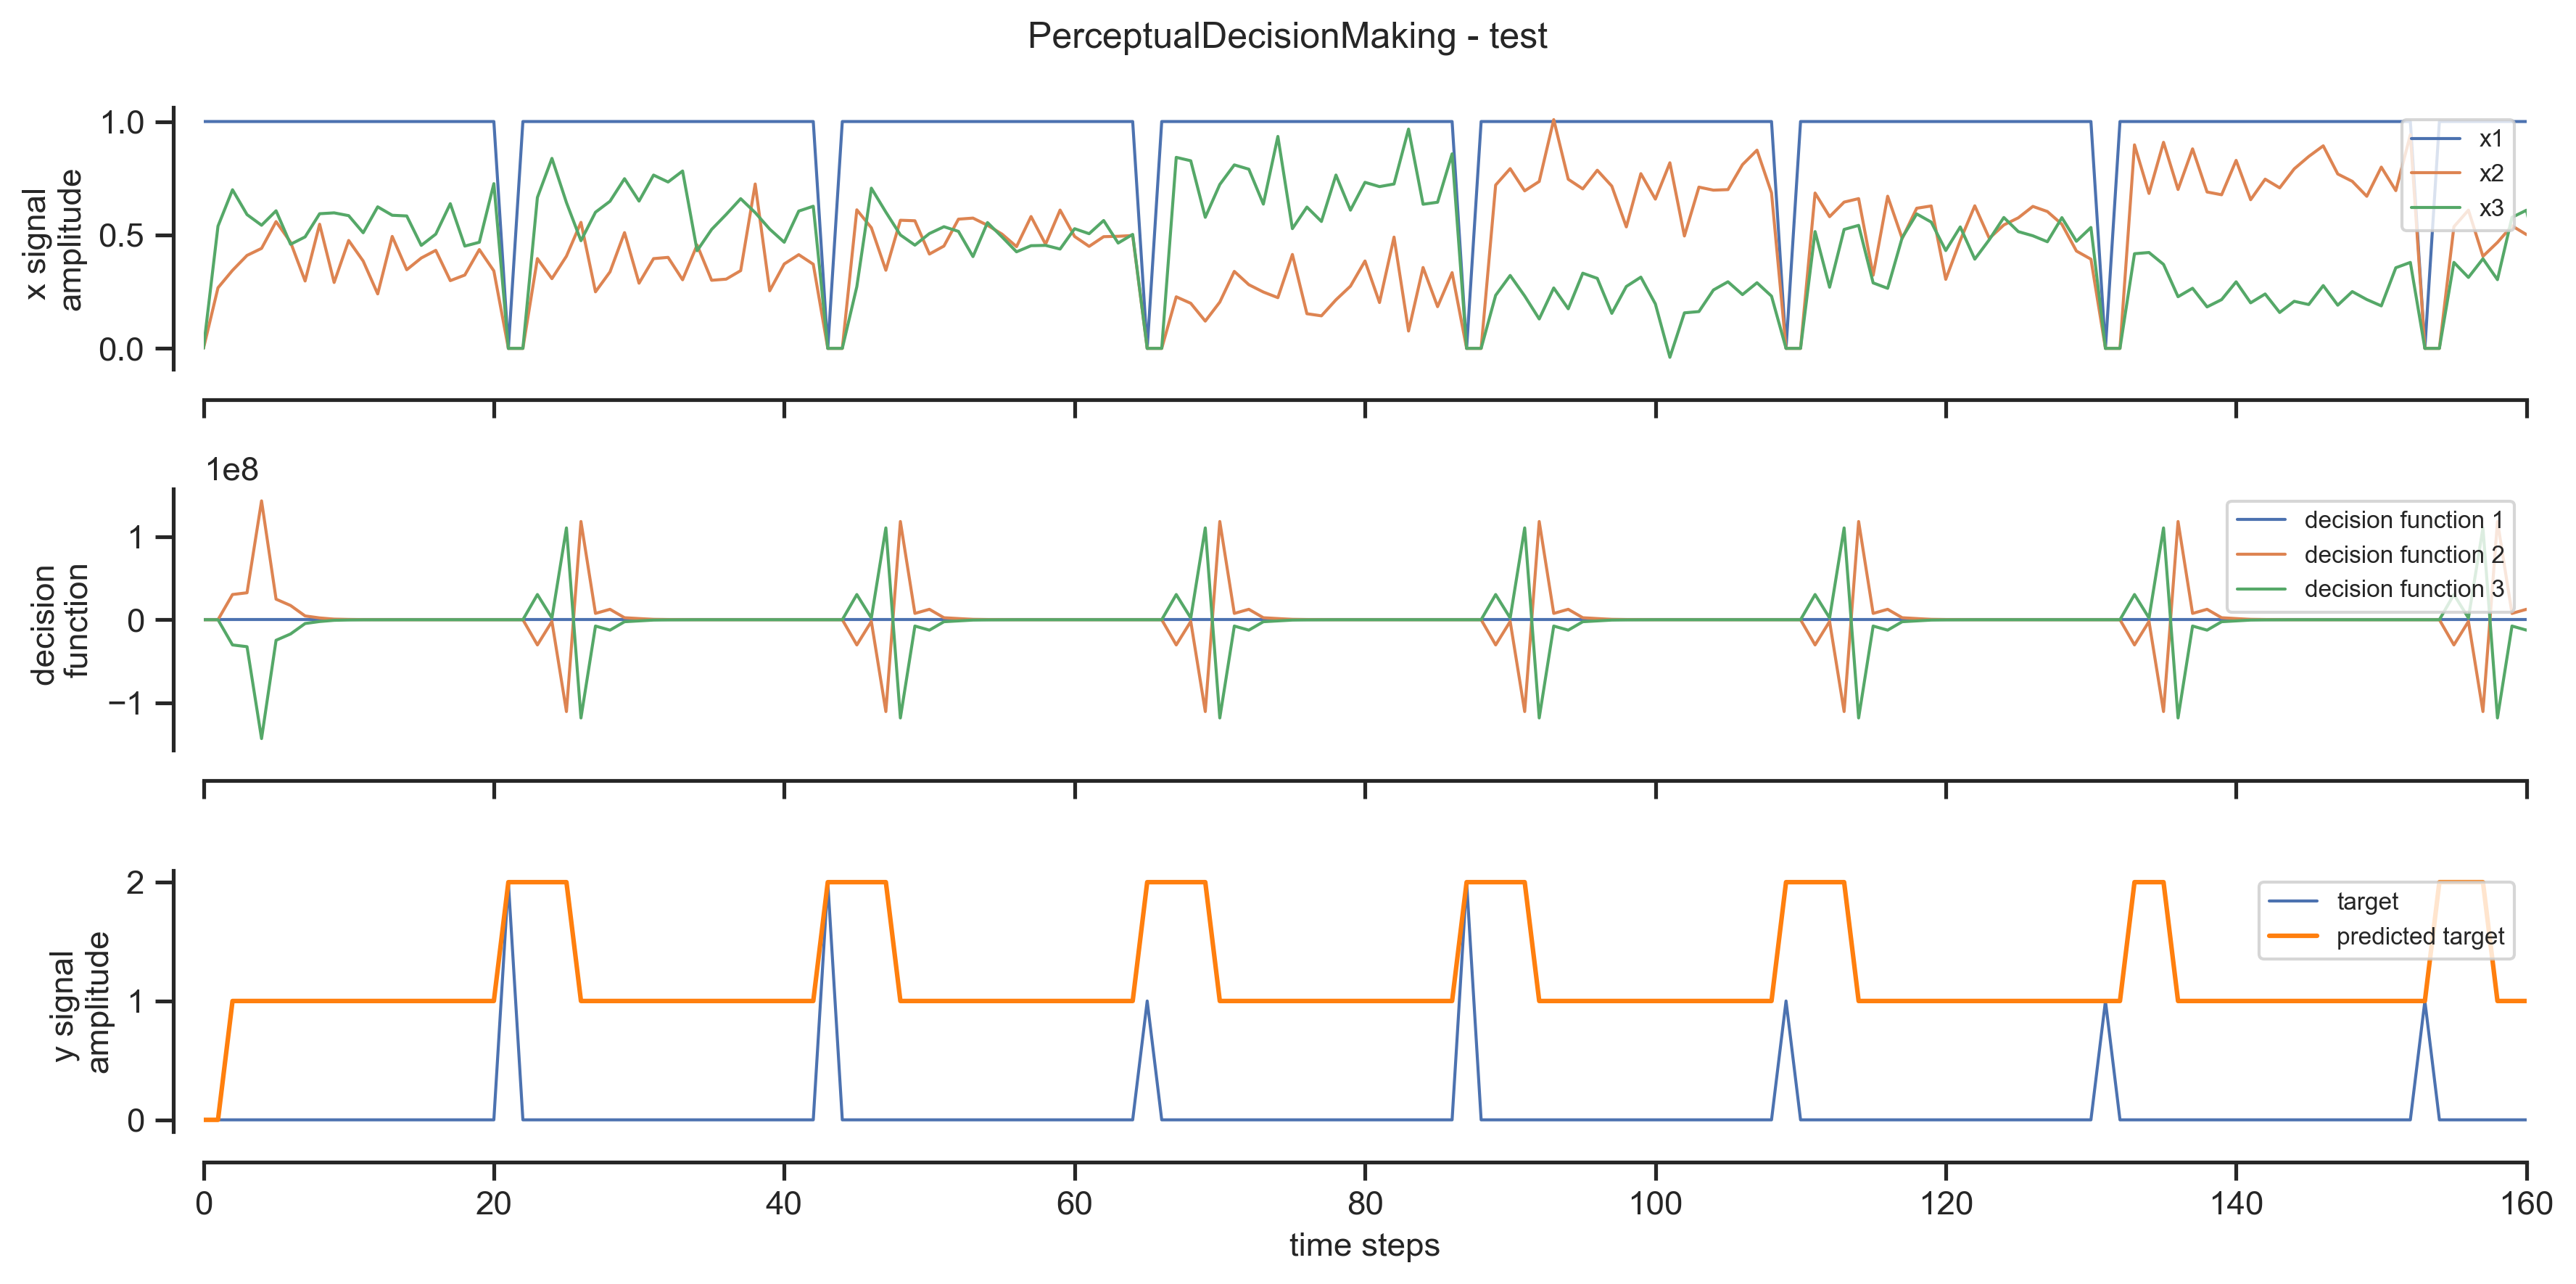


			----- alpha = 1.2 -----

			----- alpha = 1.4 -----

			----- alpha = 1.6 -----

			----- alpha = 1.8 -----

			----- alpha = 2.0 -----


In [34]:
# iterate global dynamics using different alpha values
df_alpha = []
for alpha in ALPHAS:

    print(f'\n\t\t\t----- alpha = {np.round(alpha,2)} -----')

    # scale connectivity matrix by alpha
    esn.w = alpha * conn.w

    # simulate reservoir states
    # w_in(input features x n_nodes) : input layer와 input node의 connectivity matrix
    # ext_input, x_train(700 trials, (time steps in 1 trial x input features)) : 시간에 따른 exteranl stimuli
    # w(n_nodes x n_nodes) : human connectome based connectivity matrix
    # input gain 
    # output nodes(219,) : motor관련한 모든 brain region 
    # reservoir state(time step X n_nodes) : 시간에 따른 각 brain region(node)의 state 저장
    # rs_train(700 trials, (time steps in 1 trial x output nodes))
    rs_train = esn.simulate(
        ext_input=x_train, w_in=w_in, input_gain=1,
        output_nodes=output_nodes
    )
    
    rs_test = esn.simulate(
        ext_input=x_test, w_in=w_in, input_gain=1,
        output_nodes=output_nodes
    )

    # plotting.plot_reservoir_states(
    #     x=x_train, reservoir_states=rs_train,
    #     title=f'{task.name} - training',
    #     rc_params={'figure.dpi': 300, 'savefig.dpi': 300},
    #     show=True
    # )

    # plot reservoir states : time step에 따른 모든 output region의 states
    if (alpha == 1):
        # print(f"x값 : {x_train}, rs값 : {rs_train}")
        plotting.plot_reservoir_states(
            x=x_train, reservoir_states=rs_train,
            title=f'{task.name} - training',
            rc_params={'figure.dpi': 300, 'savefig.dpi': 300},
            show=True
        )

        # plotting.plot_reservoir_states(
        #     x=x_test, reservoir_states=rs_test,
        #     title=f'{task.name} - test',
        #     show=True
        # )

    # perform task(readout layer train + test)
    # metric : readout model performance evaluation 기준 list
    # sample_wieght(700/300 trials, time steps in 1 trial x 1) : class1(결과값이 2 종류 이상, baseline 포함 x)인 경우, y가 baseline일 때 0, 결과값일 때 1
    # readout nodes
    # df_res : return value, data frame(1 x METRICS item #)
    df_res = readout_module.run_task(
        X=(rs_train, rs_test), y=(y_train, y_test),
        sample_weight='both', metric=METRICS,
        readout_modules=None, readout_nodes=None,
    )

    # df_alpha : data frame(1 x (METRICS items, alpha))
    df_res['alpha'] = np.round(alpha, 3)    # df_res에 'alpha' column 추가
    df_alpha.append(df_res)

    # plot decision-making function
    if (alpha == 1):
        plotting.plot_diagnostics(
            x=x_train, y=y_train, reservoir_states=rs_train,
            trained_model=readout_module.model, title=f'{task.name} - training',
            rc_params={'figure.dpi': 300, 'savefig.dpi': 300},
            show=True
        )
        plotting.plot_diagnostics(
            x=x_test, y=y_test, reservoir_states=rs_test,
            trained_model=readout_module.model, title=f'{task.name} - test',
            rc_params={'figure.dpi': 300, 'savefig.dpi': 300},
            show=True
        )
           
# concatenate results across alpha values
df_alpha = pd.concat(df_alpha, ignore_index=True)

Finally, let's visualize task performance.

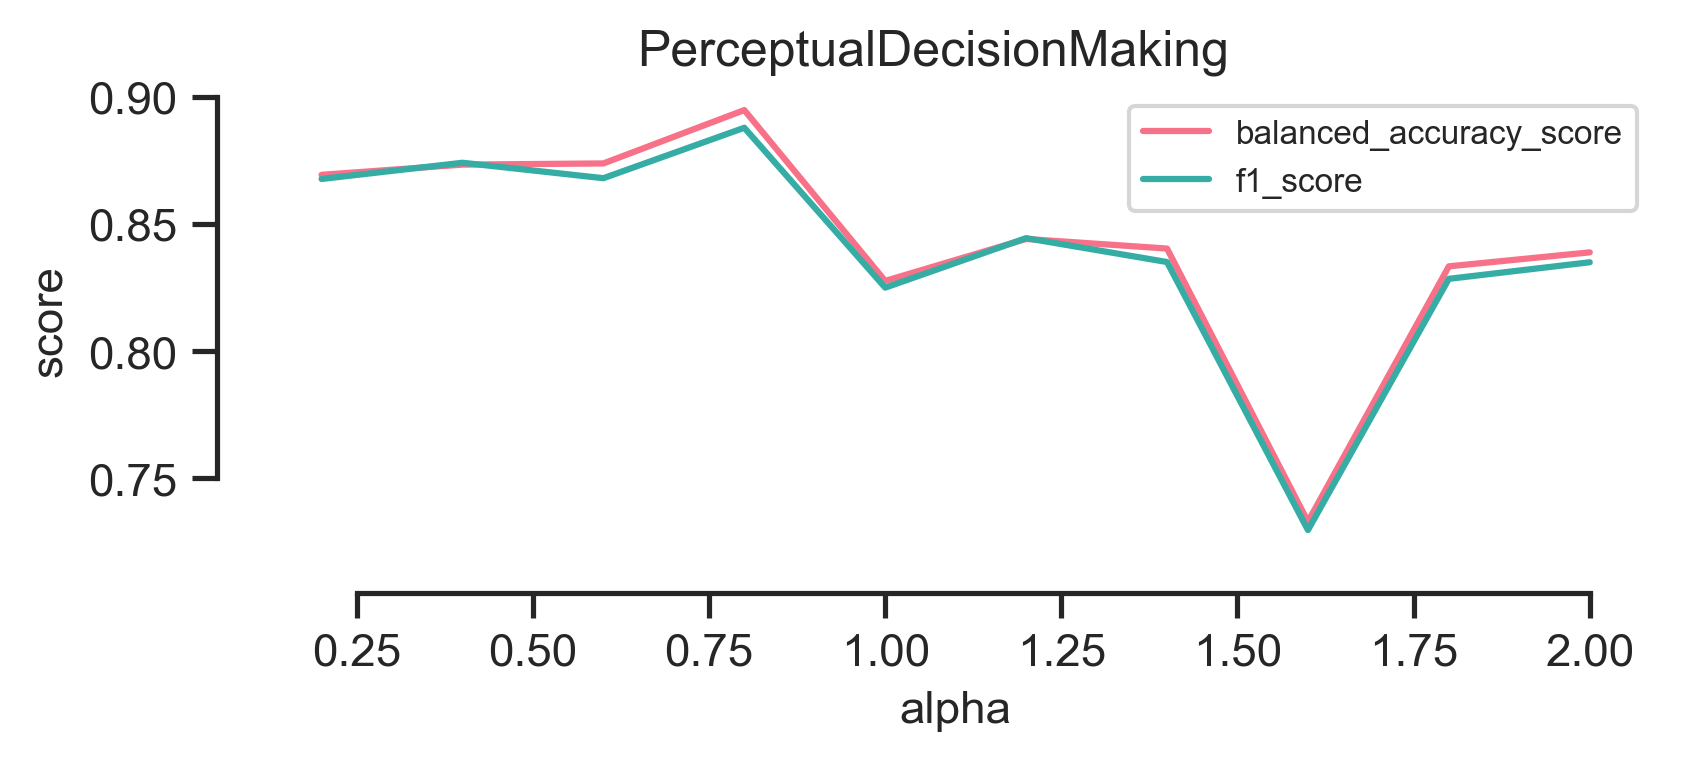

In [10]:
from conn2res import plotting

df = pd.melt(df_alpha, 
             id_vars=['alpha'], 
             value_vars=['balanced_accuracy_score', 'f1_score'], 
             var_name='metric', 
             value_name='score'
            )


plotting.plot_performance(
        df, 
        x='alpha', y='score', 
        hue='metric',
        title=task.name,
        rc_params={'figure.dpi': 300, 'savefig.dpi': 300},
        show=True
    )

End of Tutorial !!!